# Live Lecture 1

In the Linear Algebra 1 notebook, we looked at several methods for solving a system of equations :
* Matrix inversion
* LU decomposition
* SVD decomposition

Here we will examine differences in terms of computational efficiency of these algorithms.

## Matrix Inversion using Cramer's Rule

In the Linear Algebra 1 notebook we used matrix inversion from `scipy.linalg.inv`.  This uses LU decomposition to find the inverse matrix. An alternative approach is to use Cramer's rule, which you should be familiar with.

$$A^{-1} = \frac{1}{\det{A}}C^T$$

where C is the matrix of cofactors of A (or equivalently $C^T$ is the adjugate of A). The determinant can be found using the Laplace expansion :

\begin{equation}
\det{A} = \Sigma^n_{j=1} (-1)^{i_0+j} a_{i_0j} \det{M_{i_0j}}
\end{equation}

Where $i_0$ indicates a particular row of the matrix, and $M_{ij}$ is the sub-matrix obtained by removing row i and column j of the original matrix A.

I have provided functions which implement matrix inversion using Cramer's rule in the notebook `matrix_inverse_cramer.ipynb` which you can download from Blackboard along with this one.  To load it, run the cell below (which assumes that notebook is in the same folder as this one).

To use the code in the notebook, we just need to call the function it defines, `inv_cramer(m)`, which will return the inverse of square matrix `m` using Cramer's rule.

In [1]:
import numpy as np
import scipy.linalg as linalg

# load the Cramer's rule notebook
%run ./matrix_inverse_cramer.ipynb

## Computational Efficiency

Our goal here is to compare the *cpu time* required by each method to solve a linear equations. To do this, we will generate random NxN matrix problems :

$${\bf A} \underline{x} = \underline{b}$$

We will pass each problem to each solver, record the cpu times taken, and the find the average over a large number of problems.

So first we need a method of generating random problems, ie. random ${\bf A}$ and $\underline{b}$ :

In [3]:
# use the numpy random number library
import numpy.random as random

# to get the system epsilon, so we can ignore singular matrices
import sys

# generate a random, non-singular matrix and RHS
def generate_problem(n):
    
    # generate random matrix and random vector
    m = np.random.rand(n,n)
    b = np.random.rand(n)

    # check if the matrix is singular and try again if so
    while np.linalg.cond(m) > 1/sys.float_info.epsilon:
        m = np.random.rand(n,n)
        
    return m, b

# a quick test
a, b = generate_problem(4)
print(a, b)

[[0.00207987 0.39279224 0.89444454 0.2903263 ]
 [0.71989486 0.76236168 0.53843968 0.56811999]
 [0.53487396 0.83745577 0.04610568 0.20411358]
 [0.47034631 0.48931102 0.76185733 0.57512848]] [0.5021311  0.42791562 0.75265231 0.23470867]


The three different methods we're going to compare all have a slightly different user interface.  LU decomposition has exactly what we want here, since it provides the `lu_solve()` function.  But the Cramer's rule code returns the inverse of a matrix, and SVD just returns the SVD decomposition of a matrix.  So to do a fair comparison, we need functions which all do the same thing - ie. take matrix `a` and vector `b` as arguments, and return the solution vector `x`.

In [13]:
# the same set of functions used in Linear Algebra 1 notebook for comparison of numerical results
# except here I have replaced scipy.linalg.inv() with inv_cramer()
# since scipy.linalg.inv() uses LU decomposition, and therefore has very similar time to scipy.linalg.lu_solve

def solve_inv(a,b):
    try:
        x = inv_cramer(a) @ b
    except linalg.LinAlgError as err:
        x = np.full_like(b,np.NaN)
    return x
    
def solve_lu(a,b):
    lu, piv = linalg.lu_factor(a)
    x = linalg.lu_solve((lu, piv), b, check_finite=False)
    return x

def solve_svd(a,b):
    u, s, vh = linalg.svd(a)
    c = np.dot(u.T,b)
    w = np.dot(np.diag(1/s),c)
    x = np.dot(vh.conj().T,w)
    return x

Finally, we write a function which generates a large number of problems, and estimates the cpu time required to solve them.  For the cpu time, we use the `timeit.Timer` library, as discussed in the Advanced Python Tutorial §6.

This function will need to :
* for each problem, calculate the time for $N_{call}$ calls to the function.  (Why?)
* repeat this $N_{repeat}$ times, and take the *minimum* time from this number of repeats.  (Why?)
* do this for $N_{prob}$ random problems, and calculate the average and std deviation over this set.

In [14]:
from timeit import Timer

# find the mean time to solve a random NxN matrix problem
# take the average over the supplied problems
# times n_call function calls, and takes the minimum time over n_rpt repeats
def time_solver(n, n_prob, n_call, n_rpt, fn):
    ts = []
    
    # repeat n_prob times
    for i in range(n_prob):
        
        # generate a problem
        m, b = generate_problem(n)
        
        # take the time for n_call calls, and repeat n_rpt times
        tt = Timer(lambda : fn(m,b)).repeat(number=n_call, repeat=n_rpt)
        
        # take the minimum from the set of repeats
        t = np.min(tt)

        # calculate the time for 1 function call
        t /= n_call
        
        ts.append(t)
    
    return np.average(ts), np.std(ts)

Next we run it over a reasonable range of N...

In [16]:
# range of N
ns = np.arange(2,16)

# arrays for mean/error time values
t1s = []
e1s = []
t2s = []
e2s = []
t3s = []
e3s = []

import time
t0= time.time()

for n in ns:
    
    if n<6:  # Cramer's rule is VERY slow, don't try it for high N
        t1, e1 = time_solver(n, 10, 1000, 3, solve_inv)
        t1s.append(t1)
        e1s.append(e1)
    
    t2, e2 = time_solver(n, 10, 10000, 3, solve_lu)
    t2s.append(t2)
    e2s.append(e2)
    
    t3, e3 = time_solver(n, 10, 10000, 3, solve_svd)
    t3s.append(t3)
    e3s.append(e3)    
    
    print("Done n =",n)

print("Finished in {:.2f} seconds".format(time.time()-t0))

Done n = 2
Done n = 3
Done n = 4
Done n = 5
Done n = 6
Done n = 7
Done n = 8
Done n = 9
Done n = 10
Done n = 11
Done n = 12
Done n = 13
Done n = 14
Done n = 15
Finished in 181.80 seconds


Now make a plot of the results...

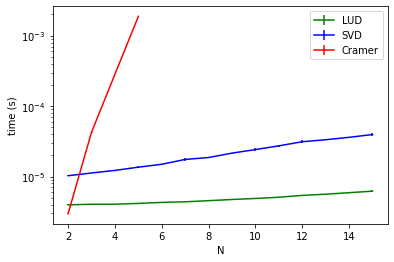

In [17]:
import matplotlib.pyplot as plt

# plot LUD as points with error bars
plt.errorbar(ns, t2s, yerr=e2s, color='g', label="LUD")
plt.errorbar(ns, t3s, yerr=e3s, color='b', label="SVD")
plt.errorbar(ns[:4], t1s, yerr=e1s, color='r', label="Cramer")

#plt.xlim(2, 5)
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("time (s)")
plt.legend()
plt.show()

Now we consider the computational complexity of these algorithms... (see accompanying slides)

In [18]:
import scipy.optimize as optimize
import scipy.special

# define a factorial function for fitting
def fit_cramer(x, a):
    return a * scipy.special.factorial(x)

# define a cubic function for LU and SVD methods
def fit_cubic(x, a, c):
    return a * x**3 + c

# fit it to the cpu-time measurements for Cramer's rule
popt1, pcov1 = optimize.curve_fit(fit_cramer, ns[:4], t1s[:4], sigma=e1s[:4])
print("Cramers rule fit : a={0:.0e}".format(popt1[0]))

# fit it to the LU data
popt2, pcov2 = optimize.curve_fit(fit_cubic, ns, t2s, sigma=e2s)
print("LU fit           : a={0:.0e} c={1:.0e}".format(popt2[0], popt2[1]))

# and fit to the SVD data
popt3, pcov3 = optimize.curve_fit(fit_cubic, ns, t3s, sigma=e3s)
print("SVD fit          : a={0:.0e} c={1:.0e}".format(popt3[0], popt3[1]))


Cramers rule fit : a=3e-06
LU fit           : a=7e-10 c=4e-06
SVD fit          : a=1e-08 c=1e-05


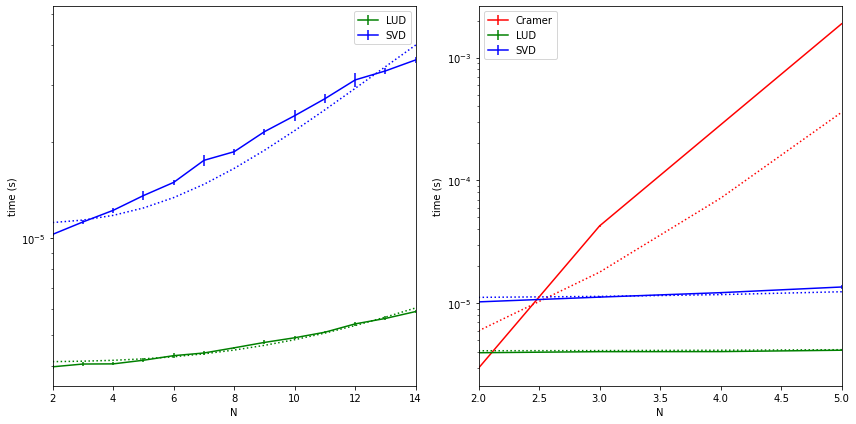

In [19]:
import matplotlib.pyplot as plt

# we'll make two plots, one of LU vs SVD, and one of all 3 on different axes
fig=plt.figure(figsize=(12, 6))

# plot 1
plt.subplot(1, 2, 1)

# plot LUD as points with error bars
plt.errorbar(ns, t2s, yerr=e2s, color='g', label="LUD")

# and then the fit results
plt.plot(ns, fit_cubic(ns, *popt2), color='g', linestyle='dotted')

# same again for SVD
plt.errorbar(ns, t3s, yerr=e3s, color='b', label="SVD")
plt.plot(ns, fit_cubic(ns, *popt3), color='b', linestyle='dotted')

# some labels and set the scale correctly
plt.xlim(2,14)
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("time (s)")
plt.legend()

# plot 2
plt.subplot(1, 2, 2)

# matrix inversion with cramer's rule, with fit results
plt.errorbar(ns[:4], t1s, yerr=e1s, color='r', label="Cramer")
plt.plot(ns[:4], fit_cramer(ns[:4], *popt1), color='r', linestyle='dotted')

# same for LU
plt.errorbar(ns, t2s, yerr=e2s, color='g', label="LUD")
plt.plot(ns, fit_cubic(ns, *popt2), color='g', linestyle='dotted')

# and for SVD
plt.errorbar(ns, t3s, yerr=e3s, color='b', label="SVD")
plt.plot(ns, fit_cubic(ns, *popt3), color='b', linestyle='dotted')

# plot labels etc.
plt.xlim(2, 5)
plt.yscale("log")
plt.xlabel("N")
plt.ylabel("time (s)")
plt.legend()

# vnow plot another version which extends the range of N and includes only LU and SVD results

plt.tight_layout()

plt.show()